In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from datetime import datetime as dt

# Load Data

In [2]:
DATASET = 'wsc-spacy'
wd = os.path.dirname('__file__')
f_name = f"{DATASET}_RESULTS.csv"
hp_name = f"{DATASET}_HP_SPACE.json"
frame_count_name = f"{DATASET}_FRAMING_COUNTS.json"

results = pd.read_csv(os.path.join(wd, f_name))
hp_space = pd.read_json(os.path.join(wd, hp_name))

with open(frame_count_name) as f:
    frame_count = json.load(f)
    

In [3]:
print(list(results.columns.values))
print(f"\n {results.shape}")

framings = results['framing'].unique()
print(framings)

['Unnamed: 0', 'level_0', 'index', 'dataset', 'framing', 'learning_rate', 'batch_size', 'max_epochs', 'seed', 'best_val_accuracy', 'exp_name', 'best_iter', 'current_iter', 'total_iter', 'early_stop']

 (201, 15)
['MC-MLM' 'P-SPAN' 'MC-SENT' 'MC-SENT-PAIR' 'MC-SENT-PLOSS' 'P-SENT'
 'MC-SENT-SCALE']


In [4]:
print(results.shape[0])
print(len(results['exp_name'].unique()))
print(list(results['learning_rate'].unique()))
print(list(results['max_epochs'].unique()))
print(list(results['batch_size'].unique()))

201
201
[3e-05, 2e-05, 1e-05]
[40, 20, 10]
[8, 16, 32, 64]


In [5]:
print(hp_space)

   learning_rate  batch_size  max_epochs    dataset
0        0.00003           8          40  wsc-spacy
1        0.00002          16          20  wsc-spacy
2        0.00001          32          10  wsc-spacy
3        0.00000          64           0  wsc-spacy


# Analyze

In [6]:
def make_box_plots(data,
                   labels, 
                   key_frame = 'framing',
                   key_acc = 'best_val_accuracy',
                   x_size = 10,
                   y_size = 5,
                   y_min = 55,
                   y_max = 100,
                   y_tick = 15,
                   y_offset = 1,
                   x_offset = .8,
                   splines_offset = 10,
                   bar_trans = 0.3,
                   colors = ['darkgrey',
                             'peachpuff',
                             'burlywood',
                             'gold',
                             'lightgreen',
                             'skyblue',
                             'plum',
                            ],
                   bar_colors = True,
                   bar_labels = True,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   notch = False,
                  ):
    
    all_scores = []
    max_scores = []
    for label in labels:
        dist = data.loc[data[key_frame]==label,key_acc]*100
        all_scores.append(dist)
        max_scores.append(max(dist))
    
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    if not title is None:
        ax.set_title(title)
    
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max+1, y_tick))
    ax.set_xticklabels(labels)
    
    if adjusted_axes:
        # Adjust plot borders
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', splines_offset))
        ax.spines['bottom'].set_position(('outward', splines_offset))
    
    ticks = np.arange(len(labels))+1
    
    if not bar_colors:
        colors = None
    
    ax.bar(ticks, max_scores, color = colors, alpha=bar_trans)
    ax.boxplot(all_scores, notch = notch, showfliers = showfliers)
    
    if bar_labels:
        for i, v in enumerate(max_scores):
            ax.text(i + x_offset, v + y_offset, "{:.2f}%".format(v))
    
    # Adjust layout
    fig.tight_layout()
    
    return fig

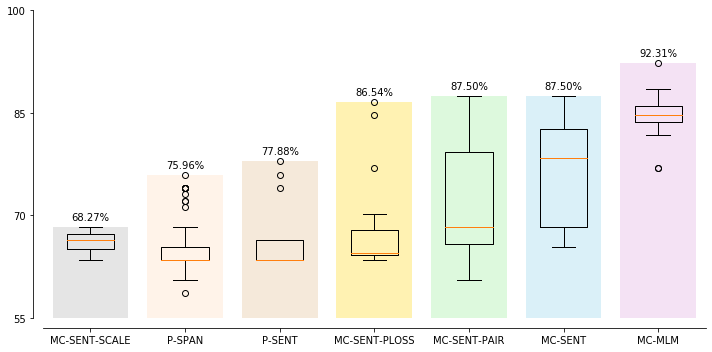

In [7]:
ordered_framings = ['MC-SENT-SCALE',
                   'P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

f = make_box_plots(results,
                   ordered_framings,
                   bar_colors = True,
                   bar_labels = True,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   notch = False,
                  )

In [8]:
def get_stats(data,
              labels,
              key_frame = 'framing',
              key_acc = 'best_val_accuracy',
             ):
    results = {label : {} for label in labels}
    
    for label, value in results.items():
        dist = data.loc[data[key_frame]==label,key_acc]
        
        value['mean'] = dist.mean()
        value['std'] = dist.std()
        value['medium'] = dist.median()
        value['1Q'] = dist.quantile(q=0.25)
        value['3Q'] = dist.quantile(q=0.75)
    
    return results

In [9]:
stats = get_stats(results,
                  ordered_framings,
                 )

print(stats)

{'MC-SENT-SCALE': {'mean': 0.659615384615, 'std': 0.014431509026577208, 'medium': 0.6634615385, '1Q': 0.65144230765, '3Q': 0.6730769231}, 'P-SPAN': {'mean': 0.6561538461538461, 'std': 0.04240747473946698, 'medium': 0.6346153846153846, '1Q': 0.6346153846153846, '3Q': 0.6538461538461539}, 'P-SENT': {'mean': 0.658173076915, 'std': 0.04536640597423123, 'medium': 0.6346153846, '1Q': 0.6346153846, '3Q': 0.6634615385}, 'MC-SENT-PLOSS': {'mean': 0.67788461537, 'std': 0.06887984611120763, 'medium': 0.6442307692, '1Q': 0.64182692305, '3Q': 0.6778846154}, 'MC-SENT-PAIR': {'mean': 0.716826923085, 'std': 0.08875781006136425, 'medium': 0.6826923077, '1Q': 0.658653846175, '3Q': 0.7932692307999999}, 'MC-SENT': {'mean': 0.76201923077, 'std': 0.07261969414435661, 'medium': 0.78365384615, '1Q': 0.6826923077, '3Q': 0.8269230769}, 'MC-MLM': {'mean': 0.8463423831070889, 'std': 0.025692350592895975, 'medium': 0.8461538461538461, '1Q': 0.8365384615384616, '3Q': 0.8605769230769231}}


# Save Stuff

In [10]:
wd = os.path.dirname('__file__')
now = dt.now().strftime("%Y%m%d_%H%M")
plot_name = os.path.join(wd, f"{DATASET}_plot_{now}.png")
stats_name = os.path.join(wd, f"{DATASET}_stats_{now}.json")

f.savefig(plot_name)
with open(stats_name, 'w') as f:
    f.write(json.dumps(stats))